In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# Load data

In [2]:
data_file = "data/updated_database.xlsx"
data = pd.read_excel(data_file, skiprows=1)
data.head()

,id,name,profile_id,width,ctd_mnw5,ctd_mnw10,ctd_mdw5,ctd_mdw10,ctd_sdw5,ctd_sdw10,...,distance,velocity,aspect_ratio,energy,needle_length,efficency_ratio,specimen_temperature,room_temperature,estimated_energy,ee_error
0,1,t_120W_600s_35mm_1,1,26.894942,26.530924,26.313482,26.719844,26.544747,0.324363,0.557932,...,35,0.058333,0.469144,72,14,0.803371,23.4,23.0,57.842714,-0.380714
1,2,t_120W_600s_35mm_2,1,24.606061,23.985410,23.817443,23.969697,23.969697,0.318666,0.498111,...,35,0.058333,0.441760,72,14,0.807702,23.6,23.0,58.154545,-58.154545
2,3,t_120W_600s_35mm_3,1,27.862069,26.851025,26.673094,26.965517,26.965517,0.484023,0.846294,...,35,0.058333,0.501605,72,14,0.840755,23.2,23.2,60.534338,-0.405672
3,4,t_120W_600s_35mm_4,1,28.784628,27.803776,27.759422,27.910328,27.910328,0.597635,0.676365,...,35,0.058333,0.530182,72,14,0.844774,23.3,23.5,60.823746,-0.303746
4,5,t_120W_600s_35mm_5,1,31.448725,30.871990,30.267964,31.106891,30.559957,0.490391,1.012356,...,35,0.058333,0.559737,72,14,0.835652,24.0,24.3,60.166932,-1.103282


### Visualization

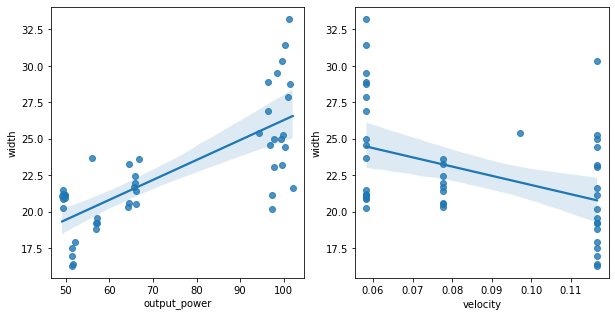

In [3]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.regplot(data = data, x = "output_power", y = "width");
plt.subplot(1, 2, 2)
sns.regplot(data = data, x = "velocity", y = "width");

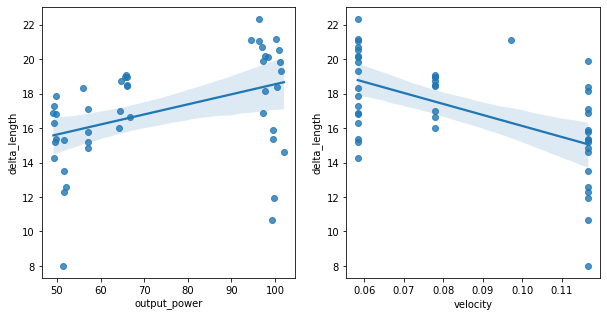

In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.regplot(data = data, x = "output_power", y = "delta_length");
plt.subplot(1, 2, 2)
sns.regplot(data = data, x = "velocity", y = "delta_length");

# Model fitting

In [5]:
X = data[['output_power', 'velocity']].values
y = data[['width', 'delta_length']].values
print(X.shape, y.shape)

(46, 2) (46, 2)


In [6]:

with pm.Model() as model:
    # define priors
    w_intercept = pm.Constant('w_intercept', 0)
    w_power = pm.Normal('w_power', 3, 2)
    w_velocity = pm.Normal('w_velocity', -3, 2)

    w_eta = pm.Exponential('w_eta', 1)
    w_eta_power = pm.Exponential('w_eta_power', 1)
    w_eta_velocity = pm.Exponential('w_eta_velocity', 1)
    
    l_intercept = pm.Normal('l_intercept', 0, 10)
    l_power = pm.Normal('l_power', 3, 2)
    l_velocity = pm.Normal('l_velocity', -1, 2)
    
    l_eta = pm.Exponential('l_eta', 1)
    l_eta_power = pm.Exponential('l_eta_power', 1)
    l_eta_velocity = pm.Exponential('l_eta_velocity', 1)
    
    # data
    X_ = pm.Data('features', X)

    # predictions width
    width_mu = pm.Deterministic('width_mu', w_intercept + w_power * np.log(X_[:,0]) + w_velocity * np.log(X_[:,1]))
    width_sd = pm.Deterministic('width_sd', w_eta + w_eta_power * X_[:,0] + w_eta_velocity * X_[:,1])
    width_obs = pm.Normal('width', width_mu, width_sd, observed=y[:,0])
    
    # predictions delta length
    length_mu = pm.Deterministic('length_mu', l_intercept + l_power * np.log(X_[:,0]) + l_velocity * np.log(X_[:,1]))
    length_sd = pm.Deterministic('length_sd', l_eta + l_eta_power * X_[:,0] + l_eta_velocity * X_[:,1])
    length_obs = pm.Normal('length', length_mu, length_sd, observed=y[:,1])
    
    # use MCMC to sample
    trace = pm.sample(return_inferencedata=False, draws=1000, tune=1000, chains=4, cores=1)
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)

    pymc_data = az.from_pymc3(trace=trace, 
                              prior=prior,
                              posterior_predictive=posterior_predictive)


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [w_intercept]
>NUTS: [l_eta_velocity, l_eta_power, l_eta, l_velocity, l_power, l_intercept, w_eta_velocity, w_eta_power, w_eta, w_velocity, w_power]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.
C:\Python\miniconda\envs\tacs\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


## Show summary

In [7]:
az.summary(pymc_data, var_names=["~width_mu", "~width_sd", "~length_mu", "~length_sd"], hdi_prob=0.95)

C:\Python\miniconda\envs\tacs\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w_intercept,0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
w_power,3.511,0.533,2.459,4.552,0.012,0.008,2012.0,2005.0,1.0
w_velocity,-2.807,0.860,-4.528,-1.153,0.019,0.014,2048.0,2014.0,1.0
l_intercept,-11.713,4.562,-20.169,-2.187,0.103,0.075,1972.0,1875.0,1.0
l_power,4.347,0.939,2.506,6.198,0.020,0.015,2188.0,1969.0,1.0
l_velocity,-4.064,0.928,-5.813,-2.212,0.017,0.012,2914.0,2219.0,1.0
w_eta,0.347,0.347,0.000,1.029,0.010,0.007,1290.0,1459.0,1.0
w_eta_power,0.032,0.006,0.020,0.044,0.000,0.000,1597.0,1168.0,1.0
w_eta_velocity,0.911,0.893,0.000,2.763,0.015,0.011,2665.0,1743.0,1.0
l_eta,0.839,0.524,0.002,1.782,0.014,0.011,1316.0,1138.0,1.0


In [8]:
# az.plot_posterior(pymc_data, var_names=["~width_mu", "~width_sd", "~length_mu", "~length_sd"]);

# Visualize predictions

In [9]:
x_new = np.vstack((np.vstack((np.linspace(0, 120, 120), np.repeat(0.1, 120))).T, 
                   np.vstack((np.linspace(0, 120, 120), np.repeat(0.05, 120))).T))
vars_to_sample = ['width_mu', 'width_sd', 'length_mu', 'length_sd']

In [10]:
x_new_power_05 = np.vstack((np.linspace(0, 120, 60), np.repeat(0.05, 60))).T
with model:
    pm.set_data({'features': x_new_power_05})
    posterior_power_05 = pm.sample_posterior_predictive(trace, var_names=vars_to_sample)

x_new_power_10 = np.vstack((np.linspace(0, 120, 120), np.repeat(0.10, 120))).T
with model:
    pm.set_data({'features': x_new_power_10})
    posterior_power_10 = pm.sample_posterior_predictive(trace, var_names=vars_to_sample)
    

In [11]:
x_new_vel_60 = np.vstack((np.repeat(60, 60), np.linspace(0, 0.12, 60))).T
with model:
    pm.set_data({'features': x_new_vel_60})
    posterior_velocity_60 = pm.sample_posterior_predictive(trace, var_names=vars_to_sample)

x_new_vel_100 = np.vstack((np.repeat(100, 60), np.linspace(0, 0.12, 60))).T
with model:
    pm.set_data({'features': x_new_vel_100})
    posterior_velocity_100 = pm.sample_posterior_predictive(trace, var_names=vars_to_sample)

In [12]:
def plot_predictions(y_pred, y_std, x_gt, y_gt, x_pred, label="", _sd=1):
    y_mean = y_pred.mean(axis=0)
    y_std = y_std.mean(axis=0)

#    plt.figure(figsize=(16, 8));
    plt.plot(x_pred, y_mean, label=f"Prediction {label} ($\mu\pm {_sd}\sigma$)");
    plt.fill_between(x_pred, y_mean - _sd*y_std, y_mean + _sd*y_std, alpha=0.33); #, label='Uncertainty ($\mu\pm\sigma$)'
    plt.legend(loc='upper left');

## Predictions for witdh

C:\Python\miniconda\envs\tacs\lib\site-packages\numpy\core\_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Python\miniconda\envs\tacs\lib\site-packages\numpy\core\_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Text(0, 0.5, 'Width (mm)')

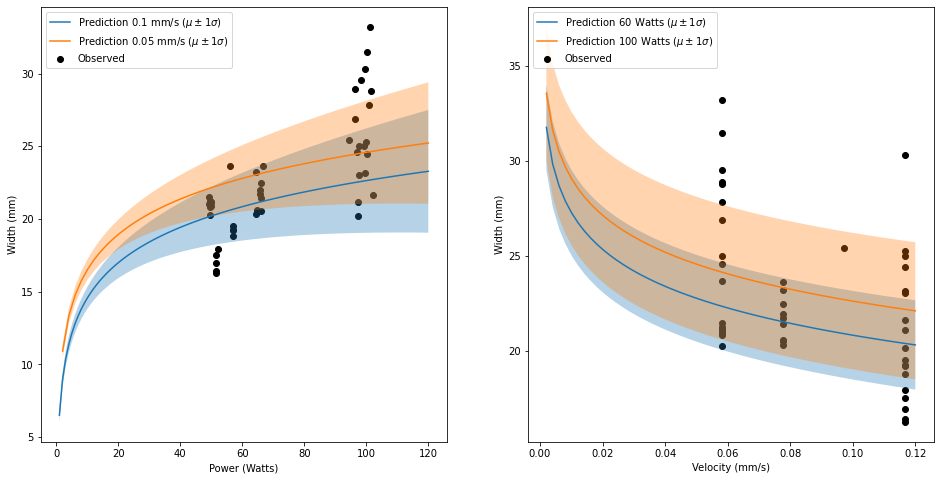

In [13]:
plt.figure(figsize=(16, 8));
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], y[:,0], color="black", label="Observed")
ix = X[:, 1] > 0.11
plot_predictions(posterior_power_10['width_mu'], posterior_power_10['width_sd'], X[ix, 0], y[ix,0], x_new_power_10[:, 0], "0.1 mm/s", _sd=1)
ix = X[:, 1] < 0.11
plot_predictions(posterior_power_05['width_mu'], posterior_power_05['width_sd'], X[ix, 0], y[ix,0], x_new_power_05[:, 0], "0.05 mm/s", _sd=1)
plt.xlabel("Power (Watts)")
plt.ylabel("Width (mm)")
#plt.ylim(0, 40)

plt.subplot(1, 2, 2)
ix = X[:, 0] < 80
plt.scatter(X[:, 1], y[:,0], color="black", label="Observed")
ix = X[:, 0] < 80
plot_predictions(posterior_velocity_60['width_mu'], posterior_velocity_60['width_sd'], X[ix, 1], y[ix,0], x_new_vel_60[:, 1], "60 Watts", _sd=1)
ix = X[:, 0] > 80
plot_predictions(posterior_velocity_100['width_mu'], posterior_velocity_100['width_sd'],X[ix, 1], y[ix,0], x_new_vel_100[:, 1], "100 Watts", _sd=1)
plt.xlabel("Velocity (mm/s)")
plt.ylabel("Width (mm)")
#plt.ylim(0, 40)

## Predictions for delta length

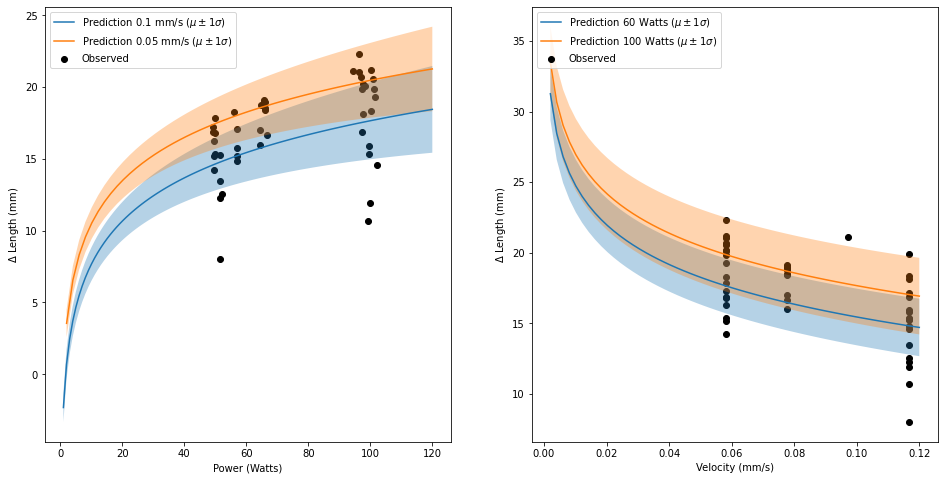

In [14]:
plt.figure(figsize=(16, 8));
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], y[:,1], color="black", label="Observed")
ix = X[:, 1] > 0.11
plot_predictions(posterior_power_10['length_mu'], posterior_power_10['length_sd'], X[ix, 0], y[ix, 1], x_new_power_10[:, 0], "0.1 mm/s", _sd=1)
ix = X[:, 1] < 0.11
plot_predictions(posterior_power_05['length_mu'], posterior_power_05['length_sd'], X[ix, 0], y[ix, 1], x_new_power_05[:, 0], "0.05 mm/s", _sd=1)
plt.xlabel("Power (Watts)")
plt.ylabel("$\Delta$ Length (mm)")
#plt.ylim(0, 40)

plt.subplot(1, 2, 2)
ix = X[:, 0] < 80
plt.scatter(X[:, 1], y[:,1], color="black", label="Observed")
ix = X[:, 0] < 80
plot_predictions(posterior_velocity_60['length_mu'], posterior_velocity_60['length_sd'], X[ix, 1], y[ix, 1], x_new_vel_60[:, 1], "60 Watts", _sd=1)
ix = X[:, 0] > 80
plot_predictions(posterior_velocity_100['length_mu'], posterior_velocity_100['length_sd'],X[ix, 1], y[ix, 1], x_new_vel_100[:, 1], "100 Watts", _sd=1)
plt.xlabel("Velocity (mm/s)")
plt.ylabel("$\Delta$ Length (mm)");
#plt.ylim(0, 40)

# Model visualization

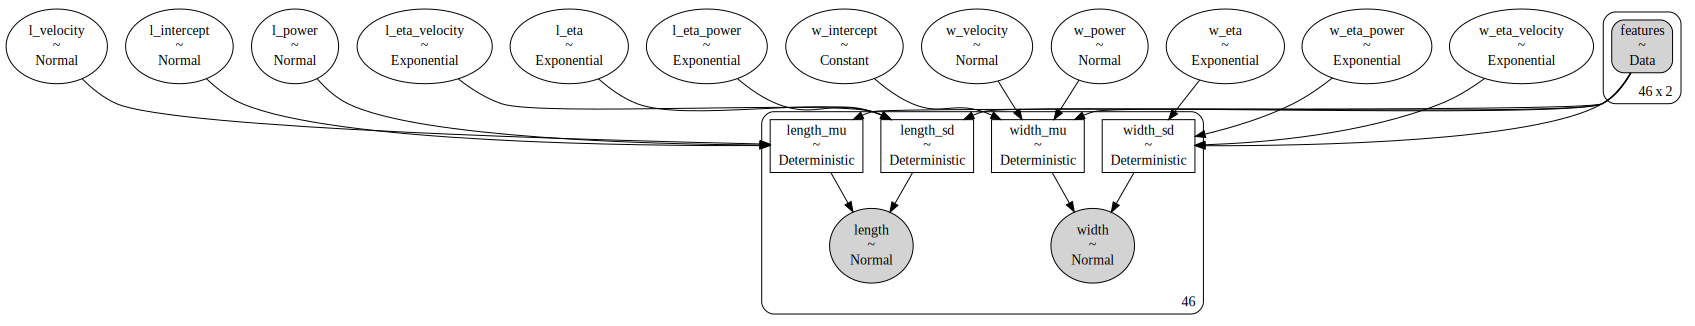

In [15]:
pm.model_to_graphviz(model)

In [16]:
pretty_model = '\n'.join([str(var ) for var in model.vars])
print(pretty_model)

w_intercept ~ Constant
w_power ~ Normal
w_velocity ~ Normal
w_eta_log__ ~ TransformedDistribution
w_eta_power_log__ ~ TransformedDistribution
w_eta_velocity_log__ ~ TransformedDistribution
l_intercept ~ Normal
l_power ~ Normal
l_velocity ~ Normal
l_eta_log__ ~ TransformedDistribution
l_eta_power_log__ ~ TransformedDistribution
l_eta_velocity_log__ ~ TransformedDistribution


In [17]:
print(model)

         w_intercept ~ Constant
             w_power ~ Normal
          w_velocity ~ Normal
         w_eta_log__ ~ TransformedDistribution
   w_eta_power_log__ ~ TransformedDistribution
w_eta_velocity_log__ ~ TransformedDistribution
         l_intercept ~ Normal
             l_power ~ Normal
          l_velocity ~ Normal
         l_eta_log__ ~ TransformedDistribution
   l_eta_power_log__ ~ TransformedDistribution
l_eta_velocity_log__ ~ TransformedDistribution
               w_eta ~ Exponential
         w_eta_power ~ Exponential
      w_eta_velocity ~ Exponential
               l_eta ~ Exponential
         l_eta_power ~ Exponential
      l_eta_velocity ~ Exponential
            width_mu ~ Deterministic
            width_sd ~ Deterministic
           length_mu ~ Deterministic
           length_sd ~ Deterministic
               width ~ Normal
              length ~ Normal
